<a href="https://colab.research.google.com/github/SageSquash/MTechImageEnhancement/blob/master/mvsiheCorrectVersionWithImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
def tanh_func(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def find_k_opt(pdf_x, lower, upper, mode):
    max_variance = -float('inf')
    k_opt = 0
    r_lower = 0
    r_upper = 0

    if mode == 'u':
        r_lower = -lower
        r_upper = -lower
    else:
        r_lower = 0
        r_upper = 0

    for i in range(lower, upper - 1):
        omega_0 = sum(pdf_x[lower + r_lower + 1 : i + r_lower + 1])
        omega_1 = sum(pdf_x[i + r_lower + 2 : upper + r_lower])
        mu_0 = 0
        if not (omega_0 == 0 or omega_1 == 0):
            for j in range(lower, i + 1):
                if j + r_lower + 1 >= len(pdf_x):
                    break
                mu_0 += (j * pdf_x[j + r_lower + 1]) / omega_0
            mu_1 = 0
            for j in range(i + 1, upper - 1):
                if j + r_lower + 1 >= len(pdf_x):
                    break
                mu_1 += (j * pdf_x[j + r_lower + 1]) / omega_1
            mu = (mu_0 * omega_0) + (mu_1 * omega_1)
            var_x = omega_0 * (mu_0 - mu) ** 2 + omega_1 * (mu_1 - mu) ** 2
            if var_x > max_variance:
                max_variance = var_x
                k_opt = i

    return k_opt

import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
import cv2

def mvsihe(x, b_delta):
    L = 256
    m, n = x.shape
    hist_x = np.histogram(x, bins=np.arange(L+1))[0]
    pdf_x = hist_x / (m * n)
    k_op2 = find_k_opt(pdf_x, 0, L, 'g')

    h_sub_1 = hist_x[:k_op2 + 1]
    h_sub_2 = hist_x[k_op2 + 1:]
    
    pdf_sub_1 = h_sub_1 / h_sub_1.sum()
    pdf_sub_2 = h_sub_2 / h_sub_2.sum()
    k_op1 = find_k_opt(pdf_sub_1, 0, k_op2, 'l')
    k_op3 = find_k_opt(pdf_sub_2, k_op2 + 1, L, 'u')
    
    bounds1 = [0, k_op1]
    bounds2 = [k_op1, k_op2]
    bounds3 = [k_op2, k_op3]
    bounds4 = [k_op3, L - 1]
    #there, a few boundary fixes
    h_sub_1 = hist_x[bounds1[0]  : bounds1[1] + 1]
    h_sub_2 = hist_x[bounds2[0] + 1 : bounds2[1] + 1]
    h_sub_3 = hist_x[bounds3[0] + 1 : bounds3[1] + 1]
    h_sub_4 = hist_x[bounds4[0] + 1 : bounds4[1] + 1]

    pdf_sub_1 = h_sub_1 / h_sub_1.sum()
    pdf_sub_2 = h_sub_2 / h_sub_2.sum()
    pdf_sub_3 = h_sub_3 / h_sub_3.sum()
    pdf_sub_4 = h_sub_4 / h_sub_4.sum()

    new_pdf_sub_1 = tanh_func(pdf_sub_1)
    new_pdf_sub_1 = new_pdf_sub_1[:, ~np.all(new_pdf_sub_1 == 0, axis=0)]

    new_pdf_sub_2 = tanh_func(pdf_sub_2)
    new_pdf_sub_2 = new_pdf_sub_2[:, ~np.all(new_pdf_sub_2 == 0, axis=0)]

    new_pdf_sub_3 = tanh_func(pdf_sub_3)
    new_pdf_sub_3 = new_pdf_sub_3[:, ~np.all(new_pdf_sub_3 == 0, axis=0)]

    new_pdf_sub_4 = tanh_func(pdf_sub_4)
    new_pdf_sub_4 = new_pdf_sub_4[:, ~np.all(new_pdf_sub_4 == 0, axis=0)]



    cdf_sub_1 = np.matmul(new_pdf_sub_1.T, np.triu(np.ones((new_pdf_sub_1.shape[0], new_pdf_sub_1.shape[0]))))
    cdf_sub_2 = np.matmul(new_pdf_sub_2.T, np.triu(np.ones((new_pdf_sub_2.shape[0], new_pdf_sub_2.shape[0]))))
    cdf_sub_3 = np.matmul(new_pdf_sub_3.T, np.triu(np.ones((new_pdf_sub_3.shape[0], new_pdf_sub_3.shape[0]))))
    cdf_sub_4 = np.matmul(new_pdf_sub_4.T, np.triu(np.ones((new_pdf_sub_4.shape[0], new_pdf_sub_4.shape[0]))))


    # # histogram equilization method
    ### you got the error in the loop because you need to add squeeze, because of the operations above. It produces a jagged np array therefore we need to reduce it by squeezing.
    fx_sub_1 = (bounds1[0] + ((bounds1[1] - bounds1[0])) * cdf_sub_1).squeeze()
    fx_sub_2 = (bounds2[0] + ((bounds2[1] - bounds2[0])) * cdf_sub_2).squeeze()
    fx_sub_3 = (bounds3[0] + ((bounds3[1] - bounds3[0])) * cdf_sub_3).squeeze()
    fx_sub_4 = (bounds4[0] + ((bounds4[1] - bounds4[0])) * cdf_sub_4).squeeze()

    m, n = x.shape
    out = np.zeros((m, n), dtype=np.uint8)

    # ## I am getting error in this loop
    # in addition, need to add -1 for true boundary values. from matlab to python it changes a bit
    for i in range(L):
        if i <= bounds1[1]:
            out[x == i] = (fx_sub_1[i])
        elif bounds1[1] < i <= bounds2[1]:
            out[x == i] = fx_sub_2[i - bounds2[0]-1]
        elif bounds2[1] < i <= bounds3[1]:
            out[x == i] = fx_sub_3[i - bounds3[0]-1]
        elif bounds3[1] < i <= bounds4[1]:
            out[x == i] = fx_sub_4[i - bounds4[0]-1]

    #############


    # # Normalisation Phase
    ### changed min(min()) to min(), it is enough for a gray image. for max too
    L_min = out.min()
    L_max = out.max()
    T_L = ((out.astype(float) - L_min) / (L_max - L_min)) * 255
    PCR_img = b_delta * T_L + (1 - b_delta) * x.astype(float)
    out = PCR_img.astype(np.uint8)


    out = np.array(out, dtype='uint8') # converting out to a numpy array
    cv2_imshow(out)
    cv2.imwrite("enhanced_image.jpg", out)
    # plt.imshow(out, cmap='gray') # display the image using imshow()
    # plt.show()


In [9]:
import math
import numpy as np
from skimage.metrics import structural_similarity as ssim

class Quantitation:
  # Absolute Mean Brightness Error
  def AMBE(self, image_input, image_output):
    return abs(np.mean(image_input) - np.mean(image_output))

  # Mean Square Error
  def MSE(self, image_input, image_output):
    # err = np.sum((image_input.astype("float") - image_output.astype("float")) ** 2)
    # err /= float(image_input.shape[0] * image_input.shape[1])
    # return err
    err = 10 * math.log10((255 * 255)/cv2.PSNR(image_input, image_output))
    return err

  # Peak Signal to Noise Ratio
  def PSNR(self, image_input, image_output):
    # return 10 * math.log10((255 * 255) / MSE(image_input, image_output))
    return cv2.PSNR(image_input, image_output)
  
  def SNR(self,  image_input, image_output):
    ibg = 0
    signal = ((image_input + image_output) / 2 - ibg).sum()
    f = (0.5 ** 0.5) * ((2 / np.pi) ** -0.5)
    noise = np.abs(image_input - image_output).sum() * f
    snr = signal / noise
    return snr

# # Convert the images to floating point arrays
#     ref = ref.astype(np.float32)
#     test = test.astype(np.float32)

# # Calculate the mean and variance of the pixel values
#     ref_mean = np.mean(ref)
#     test_mean = np.mean(test)
#     ref_var = np.var(ref)
#     test_var = np.var(test)

# # Calculate the SNR
#     snr = 20 * np.log10(np.sqrt(ref_var / test_var))
#     return snr

  def SSIM(self, image_input, image_output):
    # return ssim(image_input, image_output, win_size=1, use_sample_covariance=False)
    return ssim(image_input, image_output,multichannel=True)
  

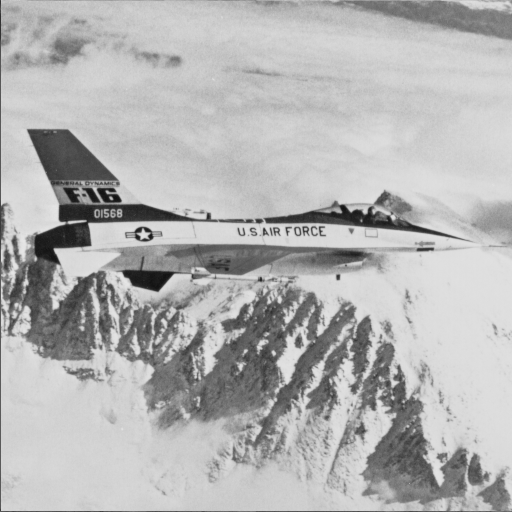

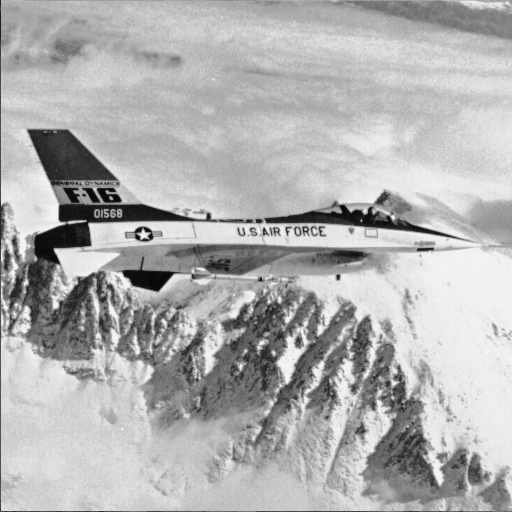

In [20]:
import cv2

# Load image
# a few fixes for my own drive (permissions)
# from google.colab import drive
# drive.mount('/content/drive')
img = cv2.imread('/content/4.2.05.tiff', cv2.IMREAD_GRAYSCALE)

from google.colab.patches import cv2_imshow
cv2_imshow(img)


mvsihe(img,0.6)

In [11]:
#####F16 image
# Load an image in grayscale
img_output = cv2.imread("/content/enhanced_image.jpg", cv2.IMREAD_GRAYSCALE)
q = Quantitation()
print(q.MSE(img,img_output))
print(q.PSNR(img,img_output))
print(q.AMBE(img,img_output))
print(q.SNR(img,img_output))
print(q.SSIM(img,img_output))
# print(calculate_entropy(img_output))

33.73700682916684
27.502975246690383
2.4283981323242188
0.8215965961314599
0.9180869590261433


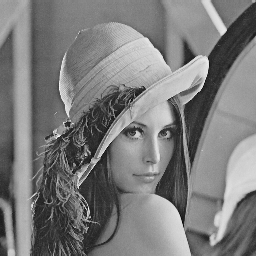

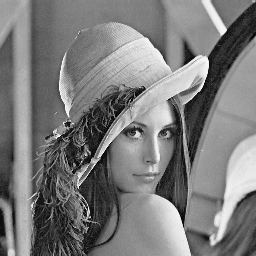

In [17]:
img = cv2.imread('/content/lena.png', cv2.IMREAD_GRAYSCALE)

from google.colab.patches import cv2_imshow
cv2_imshow(img)


mvsihe(img,0.6)

In [18]:
######LenaImage
# Load an image in grayscale
img_output = cv2.imread("/content/enhanced_image.jpg", cv2.IMREAD_GRAYSCALE)
q = Quantitation()
print(q.MSE(img,img_output))
print(q.PSNR(img,img_output))
print(q.AMBE(img,img_output))
print(q.SNR(img,img_output))
print(q.SSIM(img,img_output))
# print(calculate_entropy(img_output))

33.29547295479874
30.446197859734
0.2553558349609375
0.7744341058509536
0.9504796037298786


In [12]:
import cv2
import numpy as np
from math import log2

def image_entropy(image):
    # Read the input image in grayscale
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

    # Convert the image to a 1D array
    img_flat = img.flatten()

    # Calculate the probabilities of each intensity level
    levels, counts = np.unique(img_flat, return_counts=True)
    probabilities = counts / len(img_flat)

    # Calculate the entropy of the image
    entropy = 0
    for i in range(len(levels)):
        p_i = probabilities[i]
        entropy -= p_i * log2(p_i) if p_i != 0 else 0

    return entropy

In [21]:
entropy = image_entropy("/content/enhanced_image.jpg")
print("Entropy:", entropy)

Entropy: 7.366346961703794
